## Get the actual EP and compare it to the bound for a bunch of different R matrices
- If EP bound is varying then the system hasn't had enough time to relax (i.e. final distribution isn't fixed)

In [39]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import itertools
import scipy
import pickle
import thermo_tools


## Define global params
J = 1.
M = 1.
beta = 0.05
n = 4
N_R = 1 ## number of random R matrices

### Get initial distribution p_0 (random)
n_steps = 500+1
t_array = np.linspace(0,50,n_steps)  ## temporal evolution
p_0 = np.random.rand(np.power(2,n))
p_0 = p_0/np.sum(p_0)
    

## Get PI Matrix
spin_configs = thermo_tools.all_configs(n)
spin_df = pd.DataFrame(spin_configs)
pi_vector = []
for config in spin_configs:
    H = thermo_tools.get_H(config,M,J)
    pi_vector.append(np.exp(-beta*H))
pi_vector = pi_vector/np.sum(pi_vector) ## normalize
PI = np.diag(pi_vector)


# ## For each random R matrix, get the cumulative EP as a function of the timestep
# EP_actual_df = np.zeros((N_R,n_steps-1))
# EP_bound_df = np.zeros((N_R,n_steps-1))
EP_bound = []  # array to hold EP bound for a given R (should be independent of R if the initial and final dist is fixed)
EP_actual = []  # array to hold actual EP for a given R
for i in range(N_R):
    
    print("Analyzing Matrix ",i,"...")
    
    ## Create a random symmetric R matrix
    L = np.tril(np.random.rand(np.power(2,n),np.power(2,n)),0)  # random lower triangle
    U = np.triu(np.transpose(L),1)  # reflect the transpose for the upper triangle
    R = np.copy(L+U) # combine
    
    ## Get W matrix
    W = np.matmul(R,PI)-np.diag(np.matmul(R,pi_vector))
    W = np.transpose(W)
    
    # Make sure columns sum to zero
    for col in range(np.power(2,n)):
        if np.abs(np.sum(W[:,col])) > 1e-14:
            print("ERROR - cols should sum to one",np.sum(W[col,:]))

    # Make sure local detailed balance is satisfied
    for xx in range(n):
        for yy in range(n):
            W_ij = W[xx,yy]
            P_j = pi_vector[yy]
            W_ji = W[yy,xx]
            P_i = pi_vector[xx]
            if not np.isclose(W_ij*P_j,W_ji*P_i):
                print("ERROR - Local Detailed Balance Violated!")


    ## Integrate forward in time
    def dp_dt(p_array,t):
        return np.matmul(W,p_array)
    p_array = scipy.integrate.odeint(dp_dt,p_0,t_array)
    df = pd.DataFrame(p_array)


    # Get the bound and actual EP at all timesteps for this R matrix
    cumulative_actual = 0
    cumulative_bound = 0
    
    I_t0 = thermo_tools.I_Nstar(p_array[0],thermo_tools.get_units(n),n)
    I_tf = thermo_tools.I_Nstar(p_array[-1],thermo_tools.get_units(n),n)
    cumulative_bound = -(I_tf-I_t0) ## this is the EP bound for this timestep

    for j in range(len(df)-1):
        p_1 = df.loc[j,:]
        cumulative_actual = cumulative_actual+thermo_tools.get_EP(W,p_1)   ## this is the actual EP at this timestep
    print("\t",cumulative_actual,cumulative_bound)
    EP_bound.append(cumulative_bound) # should no longer depend on R because initial and final dist is the same
    EP_actual.append(cumulative_actual)  # should probably depend on R
    

print("DONE")

Analyzing Matrix  0 ...
	 1.9076636211744589 0.11267997204668223
DONE


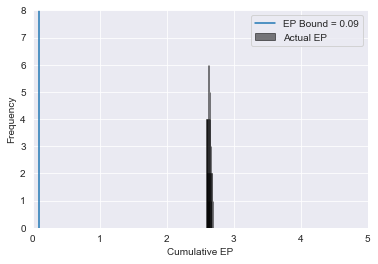

In [11]:
import seaborn as sns
sns.set_style('darkgrid')
plt.hist(EP_actual,bins=20,edgecolor='black',color='black',alpha=0.5,label='Actual EP')
plt.ylim((0,8))
plt.xlim((0,5))
plt.axvline(EP_bound[0],label='EP Bound = 0.09')
plt.xlabel('Cumulative EP')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.savefig("various_Rmatrix2.pdf")
plt.show()

In [43]:
sampling_rate = [500,250,100,50,10]

cumulative_EPs = []

for s in sampling_rate:
    print("Sampling rate = ",s)
    indices = np.linspace(0,500,s+1,dtype=int)
    new_array = np.copy(p_array[indices])
    cumulative_EP = 0.
    for i in range(len(new_array)):
        p_current = new_array[i]
        cumulative_EP = cumulative_EP + thermo_tools.get_EP(W,p_current)
        print("\t",cumulative_EP)
    cumulative_EPs.append(cumulative_EP)
    
print("DONE")

Sampling rate =  500
	 0.23616486686487592
	 0.4372994604643533
	 0.6104002448522199
	 0.7604443422168374
	 0.8911861813627528
	 1.005567955908785
	 1.1059570893050432
	 1.194295475406732
	 1.2721991305659932
	 1.3410280452037087
	 1.401936850226409
	 1.4559127185325031
	 1.5038045814039533
	 1.5463460458629845
	 1.5841735528387322
	 1.6178411098222591
	 1.6478323698437058
	 1.6745706094460315
	 1.6984270602033913
	 1.7197279191136683
	 1.7387602843513883
	 1.7557772121320798
	 1.7710020458047375
	 1.784632134232992
	 1.796842044356982
	 1.807786344929406
	 1.817602020068371
	 1.8264105694328945
	 1.8343198448595104
	 1.8414256527762252
	 1.8478131599807717
	 1.8535581257682847
	 1.8587279849052112
	 1.8633827996167027
	 1.8675760980738945
	 1.8713556135548954
	 1.8747639365311226
	 1.8778390904957274
	 1.8806150406173006
	 1.883122144279282
	 1.8853875497575057
	 1.8874355479476193
	 1.8892878850108665
	 1.890964040052257
	 1.8924814709824158
	 1.8938558319535472
	 1.8951011676843843


	 1.9076636211744205
	 1.907663621174423
	 1.9076636211744253
	 1.9076636211744276
	 1.9076636211744296
	 1.9076636211744316
	 1.9076636211744333
	 1.907663621174435
	 1.9076636211744367
	 1.9076636211744382
	 1.9076636211744395
	 1.9076636211744409
	 1.9076636211744422
	 1.9076636211744433
	 1.9076636211744444
	 1.9076636211744455
	 1.9076636211744464
	 1.9076636211744473
	 1.9076636211744482
	 1.9076636211744489
	 1.9076636211744495
	 1.9076636211744502
	 1.9076636211744509
	 1.9076636211744515
	 1.907663621174452
	 1.9076636211744524
	 1.9076636211744529
	 1.9076636211744533
	 1.9076636211744538
	 1.9076636211744542
	 1.9076636211744546
	 1.907663621174455
	 1.9076636211744553
	 1.9076636211744555
	 1.9076636211744558
	 1.907663621174456
	 1.9076636211744562
	 1.9076636211744564
	 1.9076636211744566
	 1.9076636211744569
	 1.907663621174457
	 1.9076636211744573
	 1.9076636211744575
	 1.9076636211744578
	 1.907663621174458
	 1.9076636211744582
	 1.9076636211744584
	 1.9076636211744586

	 0.23701767954704533
	 0.23701767961991288
	 0.2370176796219426
	 0.23701767962200412
	 0.23701767962200634
	 0.23701767962200643
	 0.23701767962200643
DONE


In [56]:
EP_bound[0]

0.11267997204668223

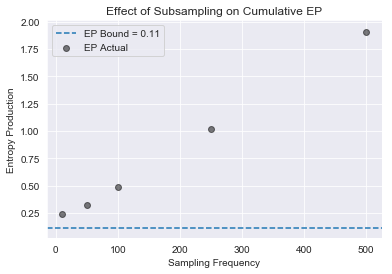

In [58]:
plt.axhline(EP_bound[0],label='EP Bound = 0.11',linestyle='dashed')
plt.scatter(sampling_rate,cumulative_EPs,alpha=0.5,color='black',label='EP Actual')
plt.xlabel('Sampling Frequency')
plt.ylabel('Entropy Production')
plt.title('Effect of Subsampling on Cumulative EP')
plt.legend(loc='best')
plt.savefig('subsample.pdf')
plt.show()

In [20]:
help(np.linspace)

Help on function linspace in module numpy:

linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
    Return evenly spaced numbers over a specified interval.
    
    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].
    
    The endpoint of the interval can optionally be excluded.
    
    .. versionchanged:: 1.16.0
        Non-scalar `start` and `stop` are now supported.
    
    Parameters
    ----------
    start : array_like
        The starting value of the sequence.
    stop : array_like
        The end value of the sequence, unless `endpoint` is set to False.
        In that case, the sequence consists of all but the last of ``num + 1``
        evenly spaced samples, so that `stop` is excluded.  Note that the step
        size changes when `endpoint` is False.
    num : int, optional
        Number of samples to generate. Default is 50. Must be non-negative.
    endpoint : bool, optional
        If True, `stop` is